## Import

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import pandas as pd
import os
import io

# Split data
from sklearn.model_selection import train_test_split

## Functions

In [2]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [3]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

## Download the Kaggle NLP-Getting-Started Dataset

The text samples of Tweets labelled as disaster or not disaster

In [4]:
url = 'https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip'

zip_dir = tf.keras.utils.get_file(origin=url, extract=True)
zip_dir

'C:\\Users\\bruce\\.keras\\datasets\\nlp_getting_started.zip'

In [5]:
base_dir = os.path.dirname(zip_dir)
train_csv = os.path.join(base_dir, 'train.csv')
test_csv = os.path.join(base_dir, 'test.csv')

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

for label, count in enumerate(train_df.target.value_counts()):
    print(f'There are {count} sentences labelled as {label} in Training dataset')

# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # frac=1 -> 100% of the data

# Split 80% Training data and 20% Validation data
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled['text'].to_numpy(),
    train_df_shuffled['target'].to_numpy(),
    train_size=0.8,
    random_state=42
)

print('---')
print('Number of Training data:', len(train_sentences))
print('Number of Validation data:', len(val_sentences))
print('Number of Testing data:', len(test_df))

There are 4342 sentences labelled as 0 in Training dataset
There are 3271 sentences labelled as 1 in Training dataset
---
Number of Training data: 6090
Number of Validation data: 1523
Number of Testing data: 3263


## Tokenization/Vectorization

In [6]:
# Average number of tokens (words) in the training tweets
max_len = round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

max_vocab_len = 10000

text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_vocab_len, # bounded the number of most occurrences of words (auto add <OOV>)
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None, # groups of n-words
    output_mode='int', # how to map tokens to numbers
    output_sequence_length=max_len, # how long the sequences to be
    pad_to_max_tokens=True
)

# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

# Get all the unique words in our training data
words_in_vocab = text_vectorizer.get_vocabulary()
count = 5
print(f'The most common {count} words are: {words_in_vocab[:count]}')
print(f'The least common {count} words are: {words_in_vocab[-count:]}')

The most common 5 words are: [['', '[UNK]', 'the', 'a', 'in']]
The least common 5 words are: [['minded', 'mindblowing', 'milne', 'milledgeville', 'millcityio']]


## Build a Transfer Learning model

universal-sentence-encoder - https://tfhub.dev/google/universal-sentence-encoder/4
* The input is variable length English text and the output is a **512** dimensional vector

In [7]:
url = 'https://tfhub.dev/google/universal-sentence-encoder/4' # model fit error: JIT compilation failed
# url = 'https://tfhub.dev/google/nnlm-en-dim50/2'
# url = 'https://tfhub.dev/google/nnlm-en-dim128/2'
# url = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2' # OOM

hub_layer = hub.KerasLayer(url, input_shape=[], dtype=tf.string, trainable=False)

In [8]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

with tf.device('/CPU:0'): # this line fix error
    model_history = model.fit(
        train_sentences,
        train_labels,
        epochs=5,
        validation_data=(val_sentences, val_labels)
    )

Epoch 1/5
191/191 [==============================] - 8s 32ms/step - loss: 0.5145 - accuracy: 0.7803 - val_loss: 0.4495 - val_accuracy: 0.7932
Epoch 2/5
191/191 [==============================] - 6s 29ms/step - loss: 0.4129 - accuracy: 0.8153 - val_loss: 0.4397 - val_accuracy: 0.7958
Epoch 3/5
191/191 [==============================] - 6s 32ms/step - loss: 0.3982 - accuracy: 0.8258 - val_loss: 0.4382 - val_accuracy: 0.8017
Epoch 4/5
191/191 [==============================] - 8s 44ms/step - loss: 0.3884 - accuracy: 0.8253 - val_loss: 0.4338 - val_accuracy: 0.8056
Epoch 5/5
191/191 [==============================] - 8s 44ms/step - loss: 0.3803 - accuracy: 0.8320 - val_loss: 0.4354 - val_accuracy: 0.8083


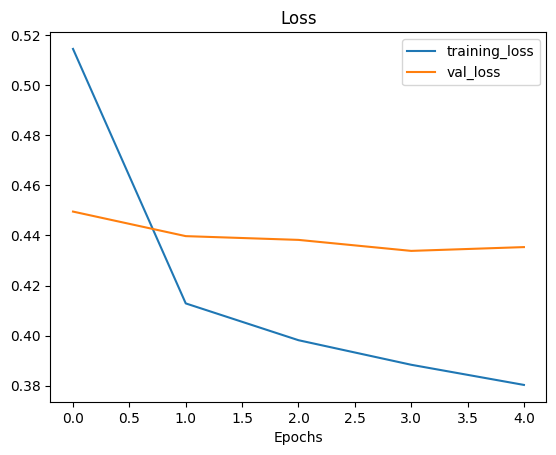

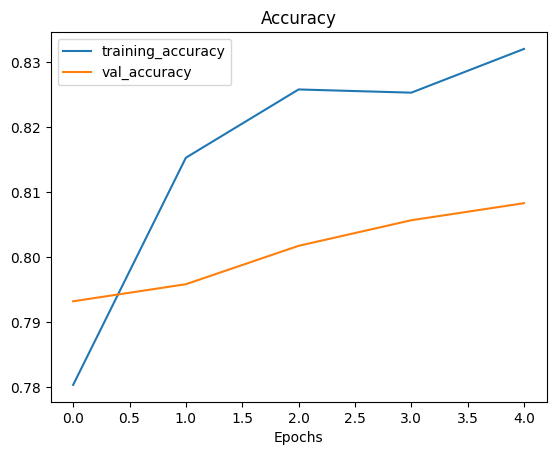

In [9]:
plot_loss_curves(model_history)

## Evaluate the mode

In [10]:
with tf.device('/CPU:0'): # this line fix error
  eval = model.evaluate(val_sentences, val_labels, verbose=1)

for name, value in zip(model.metrics_names, eval):
  print("%s: %.10f" % (name, value))

48/48 [==============================] - 1s 22ms/step - loss: 0.4354 - accuracy: 0.8083
loss: 0.4353572428
accuracy: 0.8082731366


## Predictions

In [11]:
with tf.device('/CPU:0'): # this line fix error
    pred_probs = model.predict(val_sentences)
preds = tf.squeeze(tf.round(pred_probs))
preds[:10]

48/48 [==============================] - 2s 23ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [12]:
results = calculate_results(val_labels, preds)
results

{'accuracy': 80.82731451083389,
 'precision': 0.8080427617057369,
 'recall': 0.8082731451083388,
 'f1': 0.8071921113366263}